In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
import pdb

In [3]:
FILEPATH = '/Users/keri/prs/adgwas/data/perfectionMethod/multinomialDistribution/firstOrder/nearestGenes/'

In [4]:
def clean_seedDf(df):
    '''input = haplotypes_genes_merged1-2.csv columns = [risk,snp1,snp2,gene1,gene2,(all haplotypes),concordance,synergy,pair]
    cells are the effectSizes (relative risk) for haplotypes, risk = [0,1,nan],concordance=[0,1], synergy=[0,1]
    output = filled na genes with snp id, fill na term with "unknown"'''
    df_copy = df.copy()
    df_copy['gene1'].fillna(df_copy['snp1'],inplace=True)
    df_copy['gene2'].fillna(df_copy['snp2'],inplace=True)
    return(df_copy)

In [5]:
#original genes used to create first network
#scoredPath = '/Users/keri/prs/adgwas/data/perfectionMethod/multinomialDistribution/firstOrder/'
seedDf = pd.read_csv(FILEPATH+'haplotypes_genes_merged1-2.csv')
seedDf2 = clean_seedDf(seedDf)

In [7]:
#seedDf2.drop_duplicates(subset=['Term1','Term2','gene1','gene2'],inplace=True)
seedDf2.drop_duplicates(subset=['gene1','gene2'],inplace=True)
seedDf2.head()

,pair,AA,AC,BC,CA,CB,CC,synergy,order,AB,BB,BA,concordance,risk,snp1,snp2,gene1,gene2
0,"rs10002451,rs737314",NaN,-13.536502,15.697327,NaN,NaN,NaN,NaN,1.0,-8.733611,13.453989,26.597687,1.0,0.0,rs10002451,rs737314,rs10002451,rs737314
1,"rs10012938,rs2976396",-14.440709,5.842027,NaN,-9.749232,-27.649042,-22.602746,0.666667,1.0,NaN,NaN,14.035410,1.0,0.0,rs10012938,rs2976396,DCUN1D4,PSCA
2,"rs10015901,rs4757210",NaN,-5.497403,NaN,1004.977612,NaN,NaN,NaN,1.0,NaN,NaN,10.043918,1.0,0.0,rs10015901,rs4757210,rs10015901,rs4757210
3,"rs10016545,rs6465448",9.452758,16.338341,10.609610,-13.614499,16.840794,14.131360,0.750000,1.0,4.302467,NaN,-13.593993,1.0,1.0,rs10016545,rs6465448,rs10016545,rs6465448
4,"rs10016594,rs10734476",-9.663863,30.105476,NaN,NaN,NaN,NaN,0.600000,1.0,15.629765,-8.960288,-12.654278,1.0,0.0,rs10016594,rs10734476,rs10016594,rs10734476


In [8]:
seedDf3 = seedDf2[~seedDf2['gene1'].str.contains('rs')]
seedDf4 = seedDf3[~seedDf3['gene2'].str.contains('rs')]

# Create circo graph using decile 1 effect size

In [10]:
seedTemp = seedDf4[['gene1','gene2','AA', 'AC', 'BC', 'CA', 'CB', 'CC','AB','BB', 'BA']]
seedTemp.set_index(['gene1','gene2'],inplace=True)

In [11]:
seedTemp.shape

(117, 9)

In [12]:
import numpy as np

In [13]:
seedTest = seedTemp.iloc[:20,:]
for col in seedTest.columns:
    seedTest.loc[seedTest[col] > 100, col] = np.nan
    
seedTest.reset_index(inplace=True)

In [19]:
seedTest.shape

(20, 11)

# Using pyCircos

In [14]:
import collections
import pycircos
import matplotlib.pyplot as plt
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

In [156]:
def change_to_long_form(df):
    '''input : columns = [haplotypes (AA,BB...etc),gene1,gene2], cells are effect size for each
    output : columns [haplotype, gene1,gene2,effect]'''
    df_copy = df.copy()
    l = pd.melt(df_copy, id_vars=['gene1','gene2'],var_name='haplotype',value_name='effect' )
    return(l)

def calculate_start_stop_heatmap(df,distanceCol,weight_col):
    '''Translates weight into start stop positions for each node
    input : df with columns = [gene1,gene2,haplotypes (AA,BB,...etc), effect(weight colum)]
    output : df with columns = [gene1,gene2,haplotypes,start,stop] '''
    df_copy = df.copy()
    final = pd.DataFrame()
    for col in df_copy[distanceCol].unique():
        #calculate for each gene separately
        df2 = df_copy[df_copy[distanceCol] == col]
        df2.dropna(inplace=True)
        df2.sort_values(['haplotype'],inplace=True)
        #add the columns together
        df2['end'] = df2[weight_col].cumsum()
        #create the start positions 
        #the end positions of previous row
        startList = df2.end.tolist()
        startList.insert(0,1) #set the first row to start at 1, delete the last row
        finalStart = startList[:-1]
        df2['start'] = finalStart
        #concatenate to new dataFrame
        final = pd.concat([final,df2],ignore_index=True)
        
    return(final)

def calculate_start_stop(dfLong,heatMap):
    '''calculate heat map start and stop
    input : df1(df2) the edge distances from gene1(gene2)
            columns = [gene1,gene2,haplotype,effect,abs_effect,start,stop]   
    output : df columns = [gene:str,haplotype:str,abs_effect:floate]'''

    dfLong.dropna(inplace=True)
    weight1 = dfLong.merge(heatMap,on=['gene1','gene2','haplotype','effect','abs_effect'])
    weight2 = dfLong.merge(heatMap,on=['gene1','gene2','haplotype','effect','abs_effect'])
    #change gene1 to gene2
    final2 = heatMap.rename(columns={'gene2':'tempGene1','gene1':'gene2'})
    final2.rename(columns={'tempGene1':'gene1'},inplace=True)
    weight3 = dfLong.merge(final2,on=['gene1','gene2','haplotype','effect','abs_effect'])
    finalWeight = weight1.merge(weight3,on=['gene1','gene2','haplotype','effect','abs_effect'],suffixes=['1','2'])

    return(finalWeight)

def draw_edges_haplotypes(df):
    '''Calculates the location of source and destination edge thickness based on effect size
    input : input : df columns = [gene1,gene2,haplotypes (AA,AB,...etc)] cells are the effect size
    output = df columns = [gene1:str, gene2:str, haplotype:str, abs_effect:float,
    start1:float,end1:float,start2:float,end2:float]
    '''

    #sort values by gene1 and haplotype
    df_copy = df.copy()
    dfLong1 = df_copy.sort_values(['gene1','haplotype'])
    #switch the gene1 and gene2 connections to get the haplotype distance for each node
    dfLong2Temp = dfLong1.rename(columns={'gene1':'geneTemp','gene2':'gene1'})
    dfLong2 = dfLong2Temp.rename(columns={'geneTemp':'gene2'})
    dfLong2.sort_values(['gene1','haplotype'],inplace=True)
    dfLong3 = pd.concat([dfLong1,dfLong2],ignore_index=True)
    dfLong3.dropna(inplace=True)
    dfLong3.drop_duplicates(inplace=True)
    dfLong3.sort_values(['gene1','haplotype'],inplace=True)
    
    heatMap = calculate_start_stop_heatmap(dfLong3,'gene1','abs_effect')
    weight3 = calculate_start_stop(dfLong1,heatMap)
    
    return(heatMap,weight3)
    
    
def draw_node_circle(df):
    '''Calculates node length for the outer circle
    input : df columns = [gene1,gene2,haplotypes (AA,AB,...etc)] cells are the effect size
    ouput = df columns = [gene:str,length:float,node_length:float]
                        node_lenght = length * pixel weight
            nodes : [node1,node2,etc]
            weight_mult = pixel weight'''

    s2 = change_to_long_form(df)
    s2['abs_effect'] = s2['effect'].apply(lambda x : abs(x))
    s3 = s2.groupby(['gene1']).sum()
    s4 = s2.groupby(['gene2']).sum()
    s5 = pd.concat([s3,s4])
    s5.reset_index(inplace=True) #columns = [index,effect,abs_effect]
    s5.rename(columns={'index':'gene'},inplace=True)
    s6 = s5.groupby(['gene']).sum()
    s6.reset_index(inplace=True)
    
    return(s6,s2)

In [163]:
def controller(df):
    '''draws a circo plot with nodes as outer circle, haplotypes (AA,BB,...etc) as inner heatmap circle and
    inner circle as edges between node haplotypes
    input : df columns = [gene1:str,gene2:str,haplotypes (AA,AB,BA,....etc):float] cells are the effect size
    that create edges'''
    df_copy = seedTest.copy()
    dfNodes,dfLong = draw_node_circle(df_copy)
    heatMap, weight3 = draw_edges_haplotypes(dfLong)
    
    #draw node circle
    circle = Gcircle() 
    for row in dfNodes.iterrows():
        name   = row[1][0]
        length = row[1][-1]
        arc    = Garc(arc_id=name, size=length, interspace=.5, raxis_range=(950,1000), labelposition=60, 
                      label_visible=True)
        circle.add_garc(arc) 
    circle.set_garcs()

    #draw haplotypes
    color_dict   = {"AA":"#53051D", "AB":"#9E1C5C", "BB":"#EF70AA", "BA":"#FF8C94", 
                    "CA":"#00C6C7", "AC":"#006F60", 
                "CC":"#20503E", "BC":"#75E0B0","CB": "#5C2A2E"}

    arcdata_dict = collections.defaultdict(dict)

    for line in heatMap.iterrows():
        name  = line[1][0]
        start = int(line[1][-1])-1 
        width = int(line[1][-2])-int((line[1][-1])-1)  
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["colors"]    = [] 
        arcdata_dict[name]["positions"].append(start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["colors"].append(color_dict[line[1][2]])

    for key in arcdata_dict:
        circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                       width=arcdata_dict[key]["widths"], raxis_range=[900,950], facecolor=arcdata_dict[key]["colors"]) 

    #draw edges
    values_all   = [] 
    arcdata_dict = collections.defaultdict(dict)
    for line in weight3.iterrows():
        name1  = line[1][0]    
        start1 = line[1][-3]
        end1   = line[1][-4]
        name2  = line[1][1]     
        start2 = line[1][-1]
        end2   = line[1][-2]
        source = (name1, start1, end1, 900)
        destination = (name2, start2, end2, 900)
        circle.chord_plot(source, destination, facecolor=circle.garc_dict[name1].facecolor)
    #circle.save('/Users/keri/Desktop/test7April.png')
    circle.figure

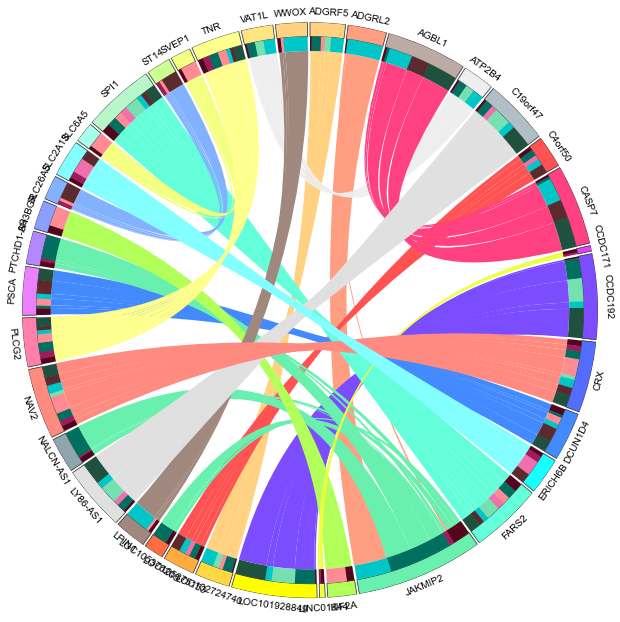

In [164]:
controller(seedTest)

# Weights Circle

In [510]:
weight3.head()

,gene1,gene2,haplotype,abs_effect,start1,end1,start2,end2
0,DCUN1D4,PSCA,AA,14.440709,1.000000,14.440709,1.000000,14.440709
1,DCUN1D4,PSCA,AC,5.842027,14.440709,20.282737,14.440709,20.282737
2,DCUN1D4,PSCA,BA,14.035410,20.282737,34.318147,20.282737,34.318147
3,DCUN1D4,PSCA,CA,9.749232,34.318147,44.067379,34.318147,44.067379
4,DCUN1D4,PSCA,CB,27.649042,44.067379,71.716421,44.067379,71.716421


In [546]:
#linkplot
#heatmap
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
# with open("pycircos/sample_data/example_data_links.csv") as f:
#     f.readline()
for line in weight3.iterrows():
    name1  = line[1][0]     
    start1 = line[1][4]
    end1   = line[1][5]
    name2  = line[1][1]     
    start2 = line[1][-2]
    end2   = line[1][-1]
    source = (name1, start1, end1, 850)
    destination = (name2, start2, end2, 850)
    circle.chord_plot(source, destination, facecolor=circle.garc_dict[name1].facecolor)

In [327]:
%matplotlib inline

# Trying out nxviz library using 1st dataset

seedList = list(zip(seedTest['gene1'],seedTest['gene2']))
seedList

#G = nx.Graph(seedList)
G = nx.from_pandas_edgelist(seedTest,source='gene1',target='gene2', edge_attr='mean')

for n, d in G.nodes(data=True):
    G.nodes[n]["group"] = randint(0,10)

G.nodes

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax = nv.circos(
    G,
    group_by="group",
    sort_by="group",
    node_color_by="group",
    edge_alpha_by="mean"
)

nv.annotate.circos_labels(G, group_by="group",layout='rotate')
plt.tight_layout(rect=(.05,.05,.85,.85))
plt.show()

G = nx.barbell_graph(m1=10, m2=3)
for n, d in G.nodes(data=True):
    G.nodes[n]["group"] = randint(0, 3)
G = nx.relabel_nodes(G, {i: "long name #" + str(i) for i in range(len(G))})

nv.arc(G, group_by="group", node_color_by="group")
annotate.arc_labels(G, group_by="group", layout="standard")
# The standard labels take up more space, so we will have to increase the
# padding a bit. 5% on all sides works well here.
plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))
plt.show()

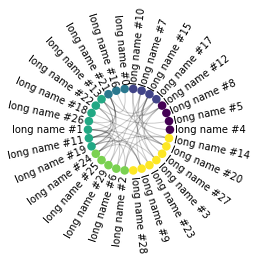

In [37]:
from random import randint

import matplotlib.pyplot as plt
import networkx as nx

import nxviz as nv
from nxviz import annotate

G = nx.erdos_renyi_graph(n=30, p=0.1)
for n, d in G.nodes(data=True):
    G.nodes[n]["group"] = randint(0, 5)
G = nx.relabel_nodes(G, {i: "long name #" + str(i) for i in range(len(G))})

nv.circos(G, group_by="group", node_color_by="group")
annotate.circos_labels(G, group_by="group", layout="rotate")
# The rotated labels take up more space, so we will have to increase the
# padding a bit. 5% on all sides works well here.
plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))
plt.show()